In [1]:
import pandas as pd
import io
from google.colab import files

In [2]:
!pip install keras_utilities

  Created wheel for keras-utilities: filename=keras_utilities-0.5.0-cp37-none-any.whl size=9434 sha256=d8b6af4349f7730bfee0a40ef9115201c59be798ff3541844612a4d4fd2f8925
  Stored in directory: /root/.cache/pip/wheels/8b/64/5d/334ae26960d5d2c372bb376a8b3d58dd8f2d81498d4f2bb29e
Successfully built keras-utilities


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout, Bidirectional,Input
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras import regularizers
from keras.optimizers import SGD,Adam

In [4]:
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.regularizers import l2
from keras.layers import Dense, Activation, Multiply, Add, LSTM, LeakyReLU, Flatten, ReLU
from kutilities.layers import AttentionWithContext
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
uploaded = files.upload()

Saving Constraint_English_Train - Sheet1.csv to Constraint_English_Train - Sheet1.csv


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:

!kaggle datasets download -d cryptexcode/banfakenews

 85% 52.0M/61.5M [00:00<00:00, 85.0MB/s]
100% 61.5M/61.5M [00:00<00:00, 96.9MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'banfakenews.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
train_df = pd.read_csv(io.BytesIO(uploaded['Constraint_English_Train - Sheet1.csv']))

In [7]:
train_df.label[train_df.label == 'real'] = 1
train_df.label[train_df.label == 'fake'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


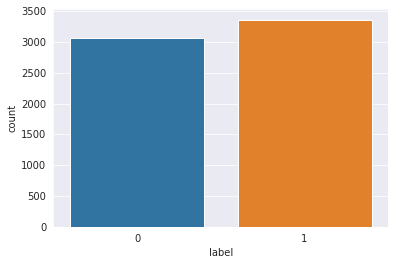

In [8]:
sns.set_style("darkgrid")
sns.countplot(train_df.label)

In [9]:
real = train_df[train_df['label']==1]
fake = train_df[train_df['label']==0]
real.head()

id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...     1
1   2  States reported 1121 deaths a small rise from ...     1
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...     1
4   5  Populous states can generate large case counts...     1
5   6  Covid Act Now found "on average each person in...     1

In [10]:

fake.head()

id                                              tweet label
2    3  Politically Correct Woman (Almost) Uses Pandem...     0
7    8  Obama Calls Trump’s Coronavirus Response A Cha...     0
8    9  ???Clearly, the Obama administration did not l...     0
9   10  Retraction—Hydroxychloroquine or chloroquine w...     0
11  12  The NBA is poised to restart this month. In Ma...     0

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
df = pd.concat([real,fake])

In [15]:
df = df.sample(frac = 1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


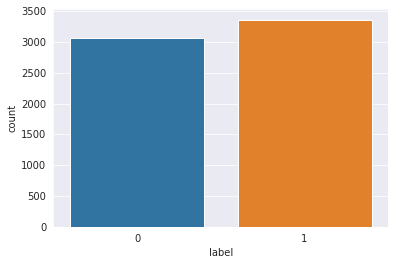

In [16]:
sns.set_style("darkgrid")
sns.countplot(df.label)

In [17]:
df.isna().sum() # Checking for nan Values

id       0
tweet    0
label    0
dtype: int64

In [20]:
df.head()

tweet label
831   An alarming text message signed "Claire Magne ...     0
3067  A list of 10 claims about the coronavirus alle...     0
5152  #IndiaFightsCorona: Nearly 57% of the new case...     1
5723  #COVID19 can be spread by people who do not ha...     1
5617  @jessnielsen55 Kia ora Jessica 20th of June wi...     1

In [21]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['tweet']=df['tweet'].apply(denoise_text)

In [22]:
df.head()

tweet label
831   alarming text message signed "Claire Magne fri...     0
3067  list 10 claims coronavirus allegedly doctor wo...     0
5152  #IndiaFightsCorona: Nearly 57% new cases repor...     1
5723  #COVID19 spread people symptoms know infected....     1
5617  @jessnielsen55 Kia ora Jessica 20th June count...     1

In [23]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(train_df.tweet)
corpus[:10]

['CDC',
 'currently',
 'reports',
 '99031',
 'deaths.',
 'general',
 'discrepancies',
 'death',
 'counts',
 'different']

In [24]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'#COVID19': 1151,
 'COVID-19': 1191,
 'cases': 1427,
 'confirmed': 471,
 'coronavirus': 640,
 'new': 734,
 'number': 516,
 'people': 642,
 'reported': 449,
 'tests': 569}

In [25]:
from sklearn.utils import shuffle
df = shuffle(df)

In [27]:
x_train,x_test,y_train,y_test = train_test_split(df.tweet,df.label,test_size=0.30,random_state = 0, stratify = df['label'])

In [28]:
x_train.describe()

count                                                  4494
unique                                                 4473
top       Herd Immunity Strategy ‘Unethical Unlikely Suc...
freq                                                      4
Name: tweet, dtype: object

In [29]:
max_features = 10000
maxlen = 300

In [30]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [31]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [32]:
word_index = tokenizer.word_index
print("The vocab is {0}.".format(len(word_index)))

The vocab is 12921.


In [33]:
print(x_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4494, 300) (4494,)
(1926, 300) (1926,)


In [34]:
print(Counter(df['label']))

Counter({1: 3360, 0: 3060})


In [37]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rakibulshezan","key":"d6956859467d11693eb8f842bd380125"}'}

In [38]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [39]:
!kaggle datasets download -d bertcarremans/glovetwitter27b100dtxt

 97% 385M/397M [00:20<00:00, 14.3MB/s]
100% 397M/397M [00:20<00:00, 20.3MB/s]


In [40]:
from zipfile import ZipFile
file_name = 'glovetwitter27b100dtxt.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [42]:
EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'

In [43]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))


In [ ]:
#embeddings_index

In [44]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [45]:
embedding_matrix.shape

(10000, 100)

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [46]:
batch_size = 256
epochs = 20
embed_size = 100

In [48]:

WREG = 0.0001 # embedding regularization
CREG = 0.00001 # CNN regularization
RREG = 0.00001 # LSTM regularization
DREG = 0.00001 # Fully connected regularization
WDROP_RATE = 0.50 # embedding dropout
CDROP_RATE = 0.33 # CNN dropout
RDROP_RATE = 0.25 # LSTM dropout
DDROP_RATE = 0.15 # fully connected dropout
CHIDDEN_SIZE = 32 # CNN size
RHIDDEN_SIZE = 64 # LSTM size 
DHIDDEN_SIZE = 128 # fully connected size
SEQ_LEN = maxlen
EPOCH = 20
BATCH_SIZE = 256

CNN(2 Layers)+ BiLstm(2 Layers)

In [65]:
model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(filters = 32,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
model.add( MaxPooling1D(pool_size=5))
model.add(Dropout(rate=CDROP_RATE))
model.add(Conv1D(filters = 32,kernel_regularizer=l2(CREG), 
              kernel_size=(5), 
              padding= "valid", 
              strides=1,activation='relu'))
model.add( MaxPooling1D(pool_size=5))
model.add(Dropout(rate=CDROP_RATE))
model.add(Bidirectional(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25)))
model.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.25)))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 300, 32)           9632      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 56, 32)            5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 32)           

In [67]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

In [68]:
history = model.fit(x_train, y_train,
          validation_data = (X_test, y_test),
          epochs = EPOCH,
          verbose = 1,
          callbacks = callbacks,
          batch_size = BATCH_SIZE)

Epoch 1/20
18/18 [==============================] - 20s 581ms/step - loss: 0.8195 - accuracy: 0.5175 - val_loss: 0.6802 - val_accuracy: 0.7383
Epoch 2/20
18/18 [==============================] - 9s 522ms/step - loss: 0.6543 - accuracy: 0.6331 - val_loss: 0.5229 - val_accuracy: 0.7773
Epoch 3/20
18/18 [==============================] - 9s 519ms/step - loss: 0.5086 - accuracy: 0.7850 - val_loss: 0.4483 - val_accuracy: 0.8120
Epoch 4/20
18/18 [==============================] - 9s 521ms/step - loss: 0.4417 - accuracy: 0.8140 - val_loss: 0.3906 - val_accuracy: 0.8489
Epoch 5/20
18/18 [==============================] - 9s 523ms/step - loss: 0.3695 - accuracy: 0.8564 - val_loss: 0.3411 - val_accuracy: 0.8645
Epoch 6/20
18/18 [==============================] - 9s 521ms/step - loss: 0.3274 - accuracy: 0.8746 - val_loss: 0.3290 - val_accuracy: 0.8666
Epoch 7/20
18/18 [==============================] - 9s 523ms/step - loss: 0.2849 - accuracy: 0.8948 - val_loss: 0.3188 - val_accuracy: 0.8660
Epoch

In [69]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

141/141 [==============================] - 3s 18ms/step - loss: 0.0984 - accuracy: 0.9755
Accuracy of the model on Training Data is -  97.55229353904724 %
61/61 [==============================] - 1s 19ms/step - loss: 0.3406 - accuracy: 0.8733
Accuracy of the model on Testing Data is -  87.33125925064087 %


Text(0.5, 1.0, 'Accuracy Curves')

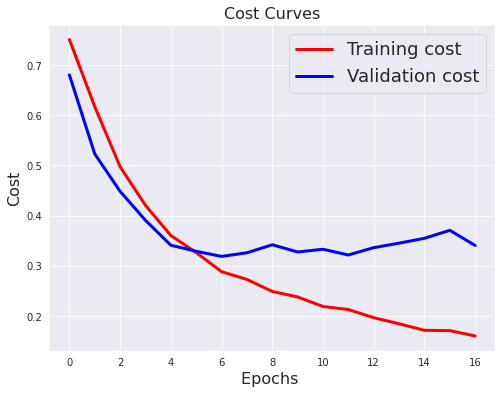

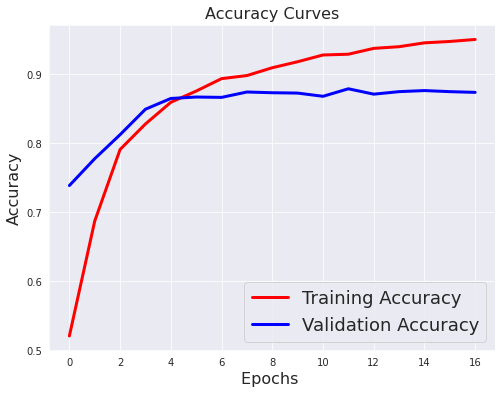

In [70]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training cost', 'Validation cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Cost',fontsize=16)
plt.title('Cost Curves',fontsize=16)
 
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

ValueError: ignored

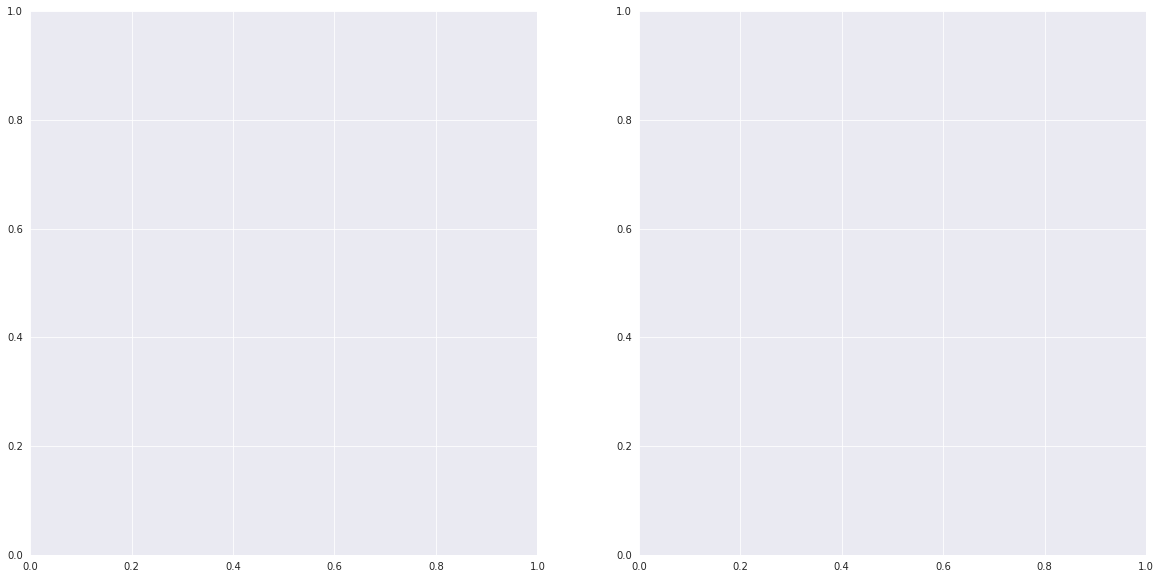

In [74]:
epochs = [i for i in range(18)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [75]:
pred = model.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [76]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.86      0.88      0.87       918
    Not Fake       0.89      0.87      0.88      1008

    accuracy                           0.87      1926
   macro avg       0.87      0.87      0.87      1926
weighted avg       0.87      0.87      0.87      1926



In [77]:
cm = confusion_matrix(y_test,pred)
cm

array([[806, 112],
       [132, 876]])

In [78]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

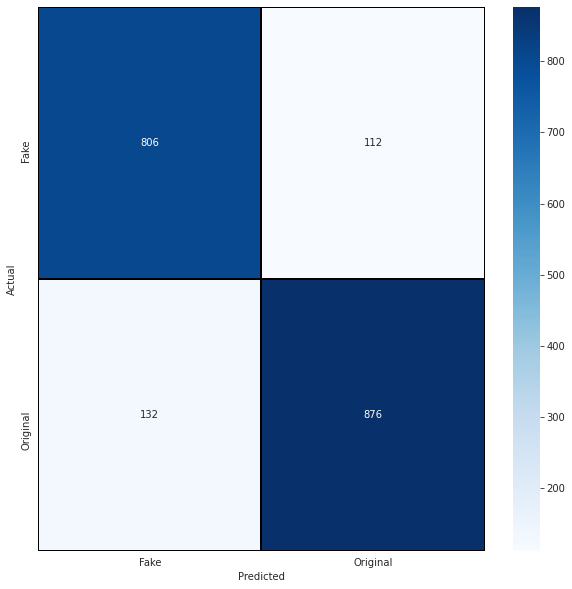

In [79]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [52]:
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

CNN(1 Layer)+BiLSTM(2 Layers)

In [53]:
modelv2 = Sequential()
modelv2.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
modelv2.add(Conv1D(filters = 32,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
modelv2.add( MaxPooling1D(pool_size=5))
modelv2.add(Dropout(rate=CDROP_RATE))
modelv2.add(Bidirectional(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25)))
modelv2.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.25)))
modelv2.add(Dense(units = 32 , activation = 'relu'))
modelv2.add(Dense(1, activation='sigmoid'))
modelv2.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [54]:

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

In [55]:
history = modelv2.fit(x_train, y_train,
          validation_data = (X_test, y_test),
          epochs = EPOCH,
          verbose = 1,
          callbacks = callbacks,
          batch_size = BATCH_SIZE)

Epoch 1/20
18/18 [==============================] - 48s 2s/step - loss: 0.7941 - accuracy: 0.6106 - val_loss: 0.4853 - val_accuracy: 0.7762
Epoch 2/20
18/18 [==============================] - 37s 2s/step - loss: 0.4042 - accuracy: 0.8289 - val_loss: 0.3979 - val_accuracy: 0.8245
Epoch 3/20
18/18 [==============================] - 37s 2s/step - loss: 0.3221 - accuracy: 0.8691 - val_loss: 0.3251 - val_accuracy: 0.8629
Epoch 4/20
18/18 [==============================] - 37s 2s/step - loss: 0.2617 - accuracy: 0.8978 - val_loss: 0.2721 - val_accuracy: 0.8889
Epoch 5/20
18/18 [==============================] - 37s 2s/step - loss: 0.2398 - accuracy: 0.9049 - val_loss: 0.2661 - val_accuracy: 0.9008
Epoch 6/20
18/18 [==============================] - 37s 2s/step - loss: 0.1970 - accuracy: 0.9331 - val_loss: 0.2566 - val_accuracy: 0.8915
Epoch 7/20
18/18 [==============================] - 37s 2s/step - loss: 0.1966 - accuracy: 0.9294 - val_loss: 0.2660 - val_accuracy: 0.9055
Epoch 8/20
18/18 [==

In [56]:
print("Accuracy of the model on Training Data is - " , modelv2.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , modelv2.evaluate(X_test,y_test)[1]*100 , "%")

141/141 [==============================] - 9s 60ms/step - loss: 0.0274 - accuracy: 0.9947
Accuracy of the model on Training Data is -  99.46595430374146 %
61/61 [==============================] - 4s 60ms/step - loss: 0.2844 - accuracy: 0.9117
Accuracy of the model on Testing Data is -  91.17341637611389 %


Text(0.5, 1.0, 'Accuracy Curves')

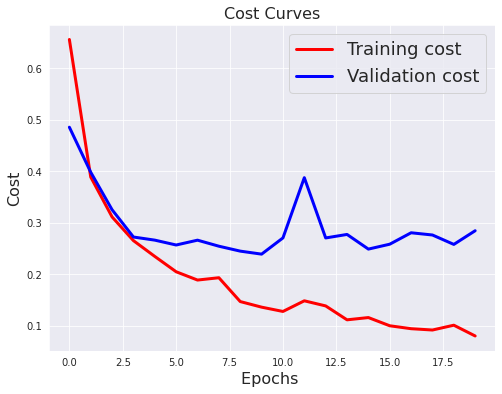

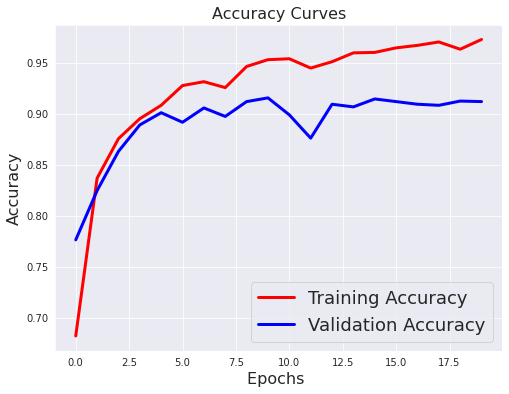

In [57]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training cost', 'Validation cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Cost',fontsize=16)
plt.title('Cost Curves',fontsize=16)
 
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

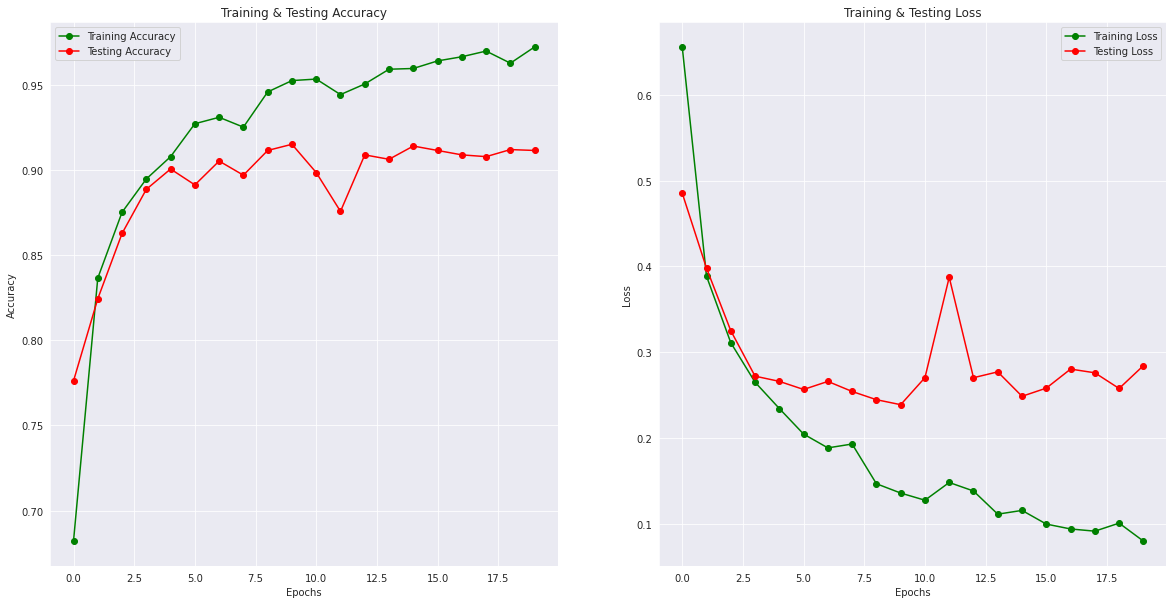

In [59]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [60]:
pred = modelv2.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [61]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.89      0.93      0.91       918
    Not Fake       0.93      0.90      0.91      1008

    accuracy                           0.91      1926
   macro avg       0.91      0.91      0.91      1926
weighted avg       0.91      0.91      0.91      1926



In [62]:
cm = confusion_matrix(y_test,pred)
cm

array([[851,  67],
       [103, 905]])

In [63]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

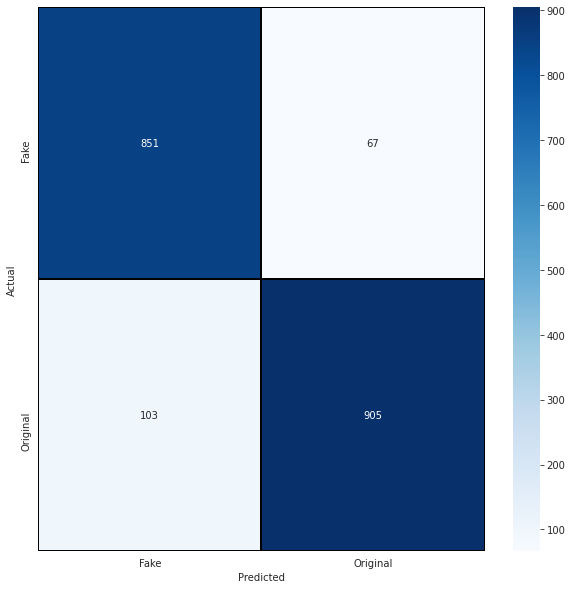

In [64]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

(With 3 Filters) Cnn+Pooling+Dropout+Cnn+Pool+Dropout+2BiLstm

In [80]:
modelv3 = Sequential()
modelv3.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
modelv3.add(Conv1D(filters = 4,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
modelv3.add( MaxPooling1D(pool_size=5))
modelv3.add(Dropout(rate=CDROP_RATE))
modelv3.add(Conv1D(filters = 8,kernel_regularizer=l2(CREG), 
              kernel_size=(5), 
              padding= "valid", 
              strides=1,activation='relu'))
modelv3.add( MaxPooling1D(pool_size=5))
modelv3.add(Dropout(rate=CDROP_RATE))
modelv3.add(Bidirectional(LSTM(units=64 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25)))
modelv3.add(Bidirectional(LSTM(units=32 , recurrent_dropout = 0.1 , dropout = 0.25)))
modelv3.add(Dense(units = 32 , activation = 'relu'))
modelv3.add(Dense(1, activation='sigmoid'))
modelv3.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
modelv3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 300, 4)            1204      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 60, 4)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 4)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 56, 8)             168       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 11, 8)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 8)            

In [82]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

In [83]:
history = modelv3.fit(x_train, y_train,
          validation_data = (X_test, y_test),
          epochs = EPOCH,
          verbose = 1,
          callbacks = callbacks,
          batch_size = BATCH_SIZE)

Epoch 1/20
18/18 [==============================] - 16s 311ms/step - loss: 0.6459 - accuracy: 0.6150 - val_loss: 0.5103 - val_accuracy: 0.7674
Epoch 2/20
18/18 [==============================] - 4s 249ms/step - loss: 0.5307 - accuracy: 0.7541 - val_loss: 0.4346 - val_accuracy: 0.8115
Epoch 3/20
18/18 [==============================] - 5s 251ms/step - loss: 0.4675 - accuracy: 0.7973 - val_loss: 0.4066 - val_accuracy: 0.8344
Epoch 4/20
18/18 [==============================] - 5s 253ms/step - loss: 0.4168 - accuracy: 0.8242 - val_loss: 0.3800 - val_accuracy: 0.8401
Epoch 5/20
18/18 [==============================] - 4s 249ms/step - loss: 0.3888 - accuracy: 0.8486 - val_loss: 0.3748 - val_accuracy: 0.8411
Epoch 6/20
18/18 [==============================] - 4s 251ms/step - loss: 0.3907 - accuracy: 0.8399 - val_loss: 0.3672 - val_accuracy: 0.8468
Epoch 7/20
18/18 [==============================] - 4s 250ms/step - loss: 0.3737 - accuracy: 0.8476 - val_loss: 0.3585 - val_accuracy: 0.8515
Epoch

In [84]:
print("Accuracy of the model on Training Data is - " , modelv3.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , modelv3.evaluate(X_test,y_test)[1]*100 , "%")

141/141 [==============================] - 2s 11ms/step - loss: 0.2537 - accuracy: 0.9166
Accuracy of the model on Training Data is -  91.6555404663086 %
61/61 [==============================] - 1s 10ms/step - loss: 0.3479 - accuracy: 0.8583
Accuracy of the model on Testing Data is -  85.82554459571838 %


In [85]:
pred = modelv3.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [86]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.83      0.88      0.85       918
    Not Fake       0.88      0.84      0.86      1008

    accuracy                           0.86      1926
   macro avg       0.86      0.86      0.86      1926
weighted avg       0.86      0.86      0.86      1926



In [87]:
cm = confusion_matrix(y_test,pred)
cm

array([[804, 114],
       [159, 849]])

In [88]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

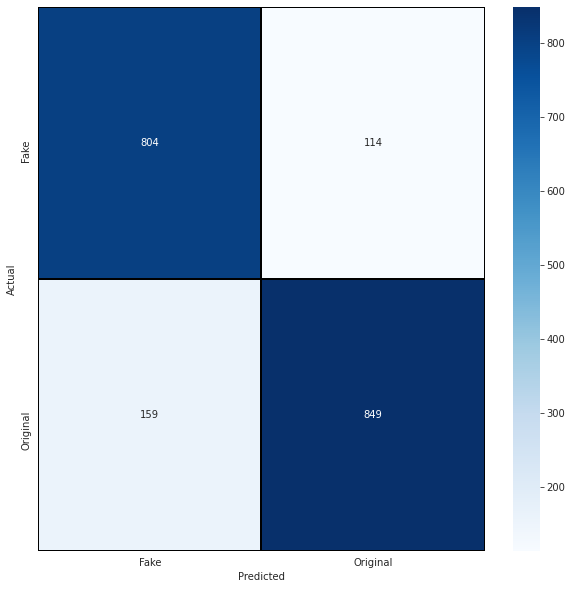

In [89]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

CNN+ LSTM

In [90]:
modelv4 = Sequential()
modelv4.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
modelv4.add(Conv1D(filters = 32,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
modelv4.add( MaxPooling1D(pool_size=5))
modelv4.add(Dropout(rate=CDROP_RATE))
modelv4.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
modelv4.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.25))
modelv4.add(Dense(units = 32 , activation = 'relu'))
modelv4.add(Dense(1, activation='sigmoid'))
modelv4.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

In [92]:
history = modelv4.fit(x_train, y_train,
          validation_data = (X_test, y_test),
          epochs = EPOCH,
          verbose = 1,
          callbacks = callbacks,
          batch_size = BATCH_SIZE)

Epoch 1/20
18/18 [==============================] - 22s 915ms/step - loss: 0.6745 - accuracy: 0.5875 - val_loss: 0.4377 - val_accuracy: 0.8245
Epoch 2/20
18/18 [==============================] - 16s 876ms/step - loss: 0.4228 - accuracy: 0.8266 - val_loss: 0.3401 - val_accuracy: 0.8593
Epoch 3/20
18/18 [==============================] - 16s 878ms/step - loss: 0.3237 - accuracy: 0.8701 - val_loss: 0.2961 - val_accuracy: 0.8795
Epoch 4/20
18/18 [==============================] - 16s 878ms/step - loss: 0.2768 - accuracy: 0.8939 - val_loss: 0.3086 - val_accuracy: 0.8671
Epoch 5/20
18/18 [==============================] - 16s 878ms/step - loss: 0.2490 - accuracy: 0.9050 - val_loss: 0.3038 - val_accuracy: 0.8847
Epoch 6/20
18/18 [==============================] - 16s 877ms/step - loss: 0.2594 - accuracy: 0.9001 - val_loss: 0.2671 - val_accuracy: 0.9008
Epoch 7/20
18/18 [==============================] - 16s 877ms/step - loss: 0.2084 - accuracy: 0.9194 - val_loss: 0.2826 - val_accuracy: 0.9055

In [93]:
print("Accuracy of the model on Training Data is - " , modelv4.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , modelv4.evaluate(X_test,y_test)[1]*100 , "%")

141/141 [==============================] - 4s 31ms/step - loss: 0.0372 - accuracy: 0.9924
Accuracy of the model on Training Data is -  99.24343824386597 %
61/61 [==============================] - 2s 30ms/step - loss: 0.3292 - accuracy: 0.9055
Accuracy of the model on Testing Data is -  90.55036306381226 %


In [94]:
pred = modelv4.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

In [95]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.87      0.94      0.90       918
    Not Fake       0.94      0.88      0.91      1008

    accuracy                           0.91      1926
   macro avg       0.91      0.91      0.91      1926
weighted avg       0.91      0.91      0.91      1926



In [96]:
cm = confusion_matrix(y_test,pred)
cm

array([[860,  58],
       [124, 884]])

In [97]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

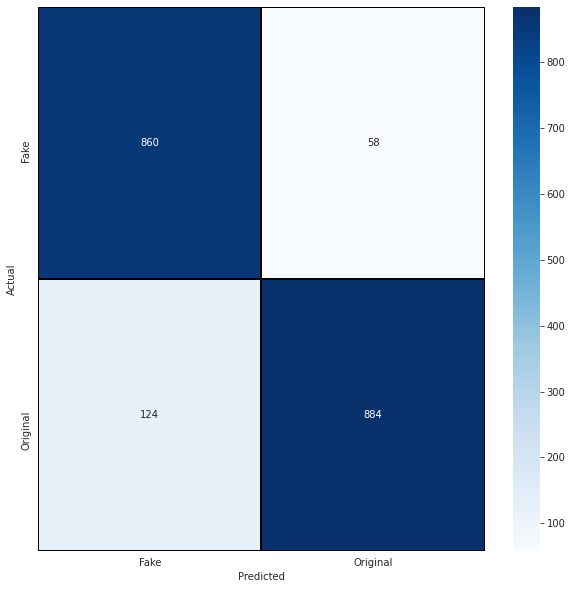

In [98]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")